In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pickle
import math
import torch.nn.init as init

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from torchvision.transforms import Lambda
class GroundTruthNoisyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.folders = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder_name = self.folders[idx]
        ground_truth_path = os.path.join(self.root_dir, folder_name, "gt.jpg")
        noisy_path = os.path.join(self.root_dir, folder_name, "noise.jpg")
        
        ground_truth = read_image(ground_truth_path)
        noisy = read_image(noisy_path)

        if self.transform:
            ground_truth = self.transform(ground_truth)
            noisy = self.transform(noisy)

        return ground_truth/255.0, noisy/255.0

In [4]:
root_tr = "/kaggle/input/256-256-image-denoising-benchmark/Image_Denoising_Data_256/Train"
root_te = "/kaggle/input/256-256-image-denoising-benchmark/Image_Denoising_Data_256/Test"

In [5]:
train_dataset = GroundTruthNoisyDataset(root_tr)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

valid_dataset = GroundTruthNoisyDataset(root_te)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class UNet_D(nn.Module):

    def __init__(self):
        super(UNet_D, self).__init__()
        self.main = MainNet(in_nc=3, out_nc=12)
        self.main2 = MainNet(in_nc=15, out_nc=24)
        self.out = nn.Conv2d(24, 3, kernel_size=3, padding=1, bias=True)

    def forward(self, x):
        out1 = self.main(x)
        out1[:,:3,:,:] = out1[:,:3,:,:] + x
        out2 = self.main2(torch.cat([x, out1], dim=1))
        out2[:, :3, :, :] = out2[:, :3, :, :] + x
        out2[:, 12:, :, :] = out2[:, 12:, :, :] + out1

        return self.out(out2) + x

class MainNet(nn.Module):
    def __init__(self, in_nc=12, out_nc=12):
        super(MainNet, self).__init__()
        self.inc = nn.Sequential(
            single_conv(in_nc, 64),
            single_conv(64, 64),
        )
        self.down1 = nn.AvgPool2d(2)
        self.conv1 = nn.Sequential(
            single_conv(64, 128),
            RDB(128, 4, 32),
        )
        self.down2 = nn.AvgPool2d(2)
        self.conv2 = nn.Sequential(
            single_conv(128, 256),
            RDB(256, 10, 32),
        )
        self.up1 = up(256)
        self.conv3 = nn.Sequential(
            RDB(128, 6, 32),
        )
        self.up2 = up(128)
        self.conv4 = nn.Sequential(
            RDB(64, 4, 32),
        )
        self.outc = outconv(64, out_nc)

    def forward(self, x):
        inx = self.inc(x)
        down1 = self.down1(inx)
        conv1 = self.conv1(down1)
        down2 = self.down2(conv1)
        conv2 = self.conv2(down2)
        up1 = self.up1(conv2, conv1)
        conv3 = self.conv3(up1)
        up2 = self.up2(conv3, inx)
        conv4 = self.conv4(up2)
        out = self.outc(conv4)
        return out

class single_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class up(nn.Module):
    def __init__(self, in_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, 2, stride=2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        return x2 + x1

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        return self.conv(x)

class RDB(nn.Module):
    def __init__(self, nChannels, nDenselayer, growthRate):
        super(RDB, self).__init__()
        nChannels_ = nChannels
        modules = []
        for i in range(nDenselayer):
            modules.append(make_dense(nChannels_, growthRate))
            nChannels_ += growthRate
        self.dense_layers = nn.Sequential(*modules)
        self.conv_1x1 = nn.Conv2d(nChannels_, nChannels, kernel_size=1, padding=0, bias=False)

    def forward(self, x):
        out = self.dense_layers(x)
        out = self.conv_1x1(out)
        return out + x

class make_dense(nn.Module):
    def __init__(self, nChannels, growthRate, kernel_size=3):
        super(make_dense, self).__init__()
        self.conv = nn.Conv2d(nChannels, growthRate, kernel_size=kernel_size, padding=(kernel_size - 1) // 2, bias=False)

    def forward(self, x):
        out = F.relu(self.conv(x))
        return torch.cat((x, out), 1)

In [7]:
model = UNet_D()

In [8]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

Using 2 GPUs!


In [9]:
import math
import torch.nn as nn
import torch

def psnr(mse, max_pixel_val=1.0):
    return 10 * math.log10(max_pixel_val**2 / mse)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses = []
train_psnr = []
test_losses = []
test_psnr = []

accumulation_steps = 4  # Define the accumulation steps

for epoch in range(num_epochs):
    total_psnr_train = 0
    tot_loss_train = 0
    model.train()
    
    optimizer.zero_grad()  # Initialize gradients once at the start of each epoch

    for i, (noisy_imgs, clean_imgs) in enumerate(train_loader):
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        current_psnr = psnr(loss.item())
        total_psnr_train += current_psnr
        tot_loss_train += loss.item()  # Using loss.item() to accumulate the loss

        loss.backward()  # Calculate gradients

        if (i+1) % accumulation_steps == 0:
            optimizer.step()  # Update weights
            optimizer.zero_grad()  # Reset gradients

    avg_psnr_train = total_psnr_train / len(train_loader)
    train_losses.append(tot_loss_train / len(train_loader))
    train_psnr.append(avg_psnr_train)
    model.eval()
    total_psnr_valid = 0
    tot_loss_valid = 0

    with torch.no_grad():
        for noisy_imgs, clean_imgs in valid_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            current_psnr = psnr(loss.item())
            total_psnr_valid += current_psnr
            tot_loss_valid += loss.item()

    avg_psnr_valid = total_psnr_valid / len(valid_loader)
    test_losses.append(tot_loss_valid / len(valid_loader))
    test_psnr.append(avg_psnr_valid)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train PSNR: {avg_psnr_train:.4f}, Valid PSNR: {avg_psnr_valid:.4f}")


Epoch [1/50], Train PSNR: 25.8920, Valid PSNR: 26.7132
Epoch [2/50], Train PSNR: 26.6963, Valid PSNR: 26.7443
Epoch [3/50], Train PSNR: 26.7677, Valid PSNR: 26.7743
Epoch [4/50], Train PSNR: 26.7471, Valid PSNR: 26.7785
Epoch [5/50], Train PSNR: 26.7140, Valid PSNR: 26.7765
Epoch [6/50], Train PSNR: 26.7232, Valid PSNR: 26.7786
Epoch [7/50], Train PSNR: 26.6990, Valid PSNR: 26.7921
Epoch [8/50], Train PSNR: 26.7810, Valid PSNR: 26.7930
Epoch [9/50], Train PSNR: 26.7329, Valid PSNR: 26.7964
Epoch [10/50], Train PSNR: 26.7764, Valid PSNR: 26.7394
Epoch [11/50], Train PSNR: 26.7410, Valid PSNR: 26.7963
Epoch [12/50], Train PSNR: 26.7178, Valid PSNR: 26.7308
Epoch [13/50], Train PSNR: 26.7513, Valid PSNR: 26.7994
Epoch [14/50], Train PSNR: 26.7447, Valid PSNR: 26.7945
Epoch [15/50], Train PSNR: 26.8169, Valid PSNR: 26.8025
Epoch [16/50], Train PSNR: 26.6735, Valid PSNR: 26.7881
Epoch [17/50], Train PSNR: 26.7708, Valid PSNR: 26.8044
Epoch [18/50], Train PSNR: 26.7907, Valid PSNR: 26.8260
E

In [10]:
train_loss = []
test_loss = []
for i in train_losses:
    train_loss.append(i)
for i in test_losses:
    test_loss.append(i)

In [11]:
print("Train_loss:",train_loss[len(train_loss)-1])
print("Test_loss:",test_loss[len(test_loss)-1])

Train_loss: 0.0022695090468253265
Test_loss: 0.0022351509261749345


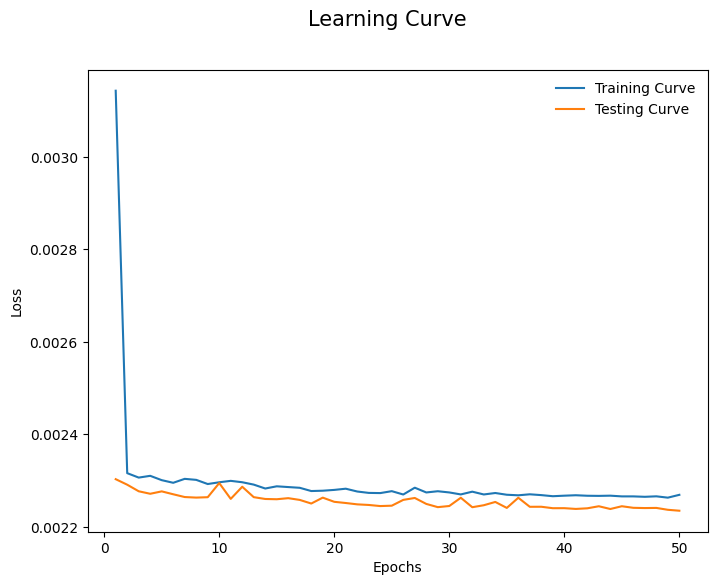

In [12]:
import matplotlib.pyplot as plt
x = [i for i in range(1,51)]
fig, ax = plt.subplots(1, figsize=(8,6))
fig.suptitle("Learning Curve", fontsize = 15)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.plot(x, train_loss, label="Training Curve")
ax.plot(x, test_loss, label="Testing Curve")
plt.legend(loc="upper right", frameon=False)
plt.show()

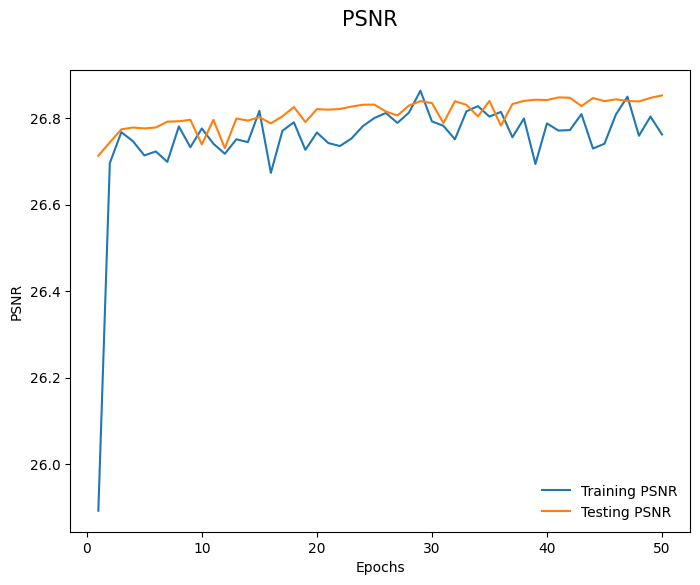

In [13]:
import matplotlib.pyplot as plt
x = [i for i in range(1,51)]
fig, ax = plt.subplots(1, figsize=(8,6))
fig.suptitle("PSNR", fontsize = 15)
ax.set_xlabel('Epochs')
ax.set_ylabel('PSNR')
ax.plot(x, train_psnr, label="Training PSNR")
ax.plot(x, test_psnr, label="Testing PSNR")
plt.legend(loc="lower right", frameon=False)
plt.show()

In [14]:
torch.save(model.module.state_dict(), 'model_unetd_denoise_256.pth')